In [1]:
!pip install pyspark

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql.types import StructType, StringType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import *

sc = SparkContext('local')
spark = SparkSession(sc)

In [49]:
# 1. Загружаем данные из файла iris.csv

df = spark.read.options(sep=",", quote='', header=True).csv('iris.csv')

In [50]:
df.show(5)

+-------------+---------------+----------------+---------------+------------+
|"sepal.length|""sepal.width""|""petal.length""|""petal.width""|""variety"""|
+-------------+---------------+----------------+---------------+------------+
|         "5.1|            3.5|             1.4|             .2| ""Setosa"""|
|         "4.9|              3|             1.4|             .2| ""Setosa"""|
|         "4.7|            3.2|             1.3|             .2| ""Setosa"""|
|         "4.6|            3.1|             1.5|             .2| ""Setosa"""|
|           "5|            3.6|             1.4|             .2| ""Setosa"""|
+-------------+---------------+----------------+---------------+------------+
only showing top 5 rows



In [51]:
# Создаем новый датафрейм из предыдущего, в котором будем использовать новые имена для колонок

newColumns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'variety']
df_new = df.toDF(*newColumns)

In [52]:
# Удаляем кавычки из значений в первой и последней колонках 

df_new = df_new.withColumn('sepal_length', regexp_replace(col('sepal_length'), '"', ''))\
               .withColumn('variety', regexp_replace(col('variety'), '"', ''))

In [53]:
# Проверяем схему нашего нового датафрейма.

df_new.printSchema()

root
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- variety: string (nullable = true)



In [54]:
# Задаем корректные типы данных для числовых значений

df_new = df_new\
    .withColumn('sepal_length', col('sepal_length').cast(DoubleType()))\
    .withColumn('sepal_width', col('sepal_width').cast(DoubleType()))\
    .withColumn('petal_length', col('petal_length').cast(DoubleType()))\
    .withColumn('petal_width', col('petal_width').cast(DoubleType()))

In [55]:
# 2. Выводим 5 первых строк данных

df_new.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [56]:
# 3. Пишем функцию, которая будет вычислять sum, avg, min и max

def agg_func(attr):
    df_new.groupBy('variety').agg(sum(attr), avg(attr), min(attr), max(attr)).show()

In [57]:
# Выводим sum, avg, min и max для каждого атрибута цветка

for i in df_new.columns[:-1]:
    agg_func(i)

+----------+------------------+-----------------+-----------------+-----------------+
|   variety| sum(sepal_length)|avg(sepal_length)|min(sepal_length)|max(sepal_length)|
+----------+------------------+-----------------+-----------------+-----------------+
| Virginica| 329.3999999999999|6.587999999999998|              4.9|              7.9|
|    Setosa|250.29999999999998|5.005999999999999|              4.3|              5.8|
|Versicolor|             296.8|            5.936|              4.9|              7.0|
+----------+------------------+-----------------+-----------------+-----------------+

+----------+------------------+------------------+----------------+----------------+
|   variety|  sum(sepal_width)|  avg(sepal_width)|min(sepal_width)|max(sepal_width)|
+----------+------------------+------------------+----------------+----------------+
| Virginica|             148.7|2.9739999999999998|             2.2|             3.8|
|    Setosa|171.40000000000003| 3.428000000000001|       

In [58]:
# Преобразуем Spark DataFrame в Pandas DataFrame

df_new_sample = df_new.toPandas()

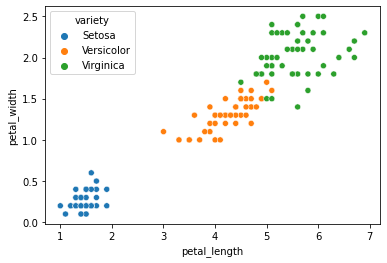

In [59]:
# 4. Строим точечную диаграмму для petal_length и petal_width, раскрашенную по типам цветков

sns.scatterplot(data = df_new_sample, x = 'petal_length', y = 'petal_width', hue = 'variety');

#### 5. Исходя из графика сформулируем правило: "Если значение petal_length < 2.5 и petal_width < 1, то это класс Setosa, иначе - Unknown".

In [60]:
# 6. Создаем в датафрейме новую колонку с предсказанием, исходя из сформулированного выше правила.

df_new_pr = df_new.withColumn('predict',\
                             when((df_new.petal_length < 2.5) & (df_new.petal_width < 1), lit('Setosa'))\
                             .otherwise(lit('Unknown'))
                             )
df_new_pr.show(5)

+------------+-----------+------------+-----------+-------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|predict|
+------------+-----------+------------+-----------+-------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa| Setosa|
+------------+-----------+------------+-----------+-------+-------+
only showing top 5 rows



In [61]:
# 7. Проверяем качество нашего предсказания путем подсчета количества строк

df_new_pr.agg(
    count(when(col('variety') == 'Setosa', True)), 
    count(when((col('variety') == 'Setosa') & (col('predict') == 'Setosa'), True)),
    count(when((col('variety') != 'Setosa') & (col('predict') == 'Setosa'), True))).show(vertical=True)

-RECORD 0-------------------------------------------------------------------------------
 count(CASE WHEN (variety = Setosa) THEN true END)                                | 50  
 count(CASE WHEN ((variety = Setosa) AND (predict = Setosa)) THEN true END)       | 50  
 count(CASE WHEN ((NOT (variety = Setosa)) AND (predict = Setosa)) THEN true END) | 0   



#### Делаем вывод, что сформулированное нами в п. 5 правило для исходного датасета предсказало класс цветка Setosa со 100% точностью